# Star Generative Adversarial Network (StarGAN)

    ↪ Transfer를 위해 여러개의 generator와 discriminator를 생성할 필요 없이, domain에 따라 변환이 가능하게 만든 GAN 모델

#### ▢ CGAN의 단점 보완
    (1) 한정된 도메인 변환 ==> 다중 도메인 변환
        ↪ CycleGAN은 두 개의 도메인 간 변환을 위해 설계되었기 때문에, 변환하려는 도메인이 늘어날수록, 필요한 G와 D의 갯수가 많아져야 함.
        StarGAN에선 단일 모델이 이미지와 함께 레이블을 받아 여러 도메인 간의 변환을 가능하게 함

#### ▢ StarGAN Loss
    ✔ Generator
        1. Adversarial loss
            ↪ (1) g_loss_fake = -torch.mean(out_src)
        2. reconstruction loss
            x ≒ G(G(x, c1), c2) = x''
            ↪ (2) g_loss_recon = torch.mean(torch.abs(real_img - recon_img))

        3. Classification loss : discriminator가 예측한 생성 이미지의 레이블과 실제 레이블이 일치하도록
            ↪ (3) g_loss_cls = classification_loss(out_cls, label_rnd)

        G_loss = (1) + (2) + (3)

    ✔ Discriminator
        1. Adversarial loss
            ↪ (1) d_loss_real = -torch.mean(real_out_src)
               (2) d_loss_fake = torch.mean(fake_out_src)
        2. Classification loss : 실제 이미지의 레이블을 맞출 수 있도록
            ↪ (3) d_loss_cls = classification(real_out_cls, label)

        D_loss = (1) + (2) + (3)

#### Colab Link
    https://colab.research.google.com/drive/17wRlJL-tWCDs6tj9PwdDTmdii-CzxgqG?usp=sharing

#### Reference
    https://github.com/yunjey/stargan
    https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/StarGAN_Tutorial.ipynb

In [ ]:
import os
import time
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.autograd import Variable


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# 학습 데이터 셋 MNIST 불러오기

transforms_train = transforms.Compose([
    transforms.Resize(28), # 이미지 크기를 28*28로 조절
    transforms.ToTensor(), # 이미지를 tensor type으로 변환
    transforms.Normalize([0.5], [0.5]) # 이미지 정규화. 픽셀 값 범위 -1 ~ 1, 평균 0.5, 표준편차 0.5
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

In [ ]:
def to_one_hot(labels, dimension=10):
    results = torch.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [ ]:
# latent vector를 뽑기 위한 noise 분포의 dimension
latent_dim = 100

# 일반적인 딥러닝 모델의 목표 : 데이터의 연산 결과와 실제 값의 차가 작아지도록

# 생성자의 목표 : 가짜 이미지를 생성하여 판별자가 그것을 real로 판별하도록 속이기
# 판별자의 연산 결과(0-속이기 실패 or 1-속이기 성공)와 실제 값(1)의 차(loss)를 줄이는 것
class Generator(nn.Module) :
    def __init__(self, c_dim=10) :
        super(Generator, self).__init__()

        def block(in_dim, out_dim, normalize=True) :
            layers = nn.ModuleList()
            layers.append(nn.Linear(in_dim, out_dim))

            if normalize :
                layers.append(nn.BatchNorm1d(out_dim, 0.8))
            layers.append(nn.GELU())
            return layers

        self.encoder = nn.Sequential(
            *block((1+c_dim)*28*28, 1024),
            *block(1024, 512),
            *block(512, 256),
            *block(256, latent_dim, normalize=False),
        )

        self.decoder = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1*28*28),
            nn.Tanh()
        )

    def forward(self, img, c) :                         # img : [batch_size, 1, 28, 28] c : [batch_size, c_dim=10]
        c = c.view(c.size(0), c.size(1), 1, 1)          # c: [batch_size, c_dim=10, 1, 1]
        c = c.repeat(1, 1, img.size(2), img.size(3))    # c: [batch_size, c_dim=10, 28, 28]
        cat_img = torch.cat([img, c], dim= 1)           # cat_img : [batch_size, 1+c_dim=10, 28, 28]

        flattened = cat_img.view(cat_img.size(0), -1)   # flattened : [batch_size, (1+10) * 28 * 28]
        x = self.encoder(flattened)                     # x : [batch_size, latent_dim]
        img = self.decoder(x)                           # img : [batch_size, 1*28*28]
        img = img.view(img.size(0), 1, 28, 28)          # img : [batch_size, 1, 28, 28]의 이미지 형태로 변경

        return img

# 판별자의 목표 : 생성자가 만든 가짜 이미지와 실제 이미지를 구별하기
# 판별자의 연산 결과(0-판별 성공 or 1-판별 실패)와 실제 값(0)의 차(loss)를 줄이는 것
class Discriminator(nn.Module) :
    def __init__(self, c_dim=10) :
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 16),
            nn.GELU(),
        )

        self.src = nn.Linear(16, 1)
        self.cls = nn.Linear(16, c_dim)

    def forward(self, img) :                  # img : [batch_size, 1, 28, 28]
        flattened = img.view(img.size(0), -1) # flattened = [batch_size, 784]
        output = self.model(flattened)        # output = [batch_size, 16]

        out_src = self.src(output)            # out_src = [batch_size, 1]
        out_cls = self.cls(output)            # out_cls = [batch_size, c_dim(레이블의 갯수)]

        return out_src, out_cls

In [ ]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size())
    dydx = torch.autograd.grad(outputs=y,
                                inputs=x,
                                grad_outputs=weight,
                                retain_graph=True,
                                create_graph=True,
                                only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

classification_loss = nn.CrossEntropyLoss().to(device)
lr = 0.0005

# betas( (beta1, beta2) ) : 일차 모멘트 추정치, 이차 모멘트 추정치에 대한 지수 가중 평균 계수
# 1차는 일반적으로 0.9 근처의 값 사용, 2차는 일반적으로 0.999 근처의 값 사용
# 1차가 0.5라는건 모멘텀에 더 빠른 변화를 반영하도록 조절하는 것, GAN 학습에서는 종종 이렇게 사용됨
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=((0.5, 0.999)))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=((0.5, 0.999)))

[Epoch 1/20] [D loss: -7.932655] [G loss: -11.459203] [Elapsed time: 158.05s]
[Epoch 2/20] [D loss: -7.889781] [G loss: -10.892165] [Elapsed time: 316.13s]
[Epoch 3/20] [D loss: -8.773831] [G loss: -10.175649] [Elapsed time: 467.21s]
[Epoch 4/20] [D loss: -7.246150] [G loss: -13.346231] [Elapsed time: 614.33s]
[Epoch 5/20] [D loss: -7.550045] [G loss: -11.498082] [Elapsed time: 767.00s]
[Epoch 6/20] [D loss: -7.328662] [G loss: -9.577385] [Elapsed time: 921.99s]
[Epoch 7/20] [D loss: -6.967762] [G loss: -10.181419] [Elapsed time: 1072.91s]
[Epoch 8/20] [D loss: -6.917224] [G loss: -9.016384] [Elapsed time: 1223.75s]
[Epoch 9/20] [D loss: -6.346043] [G loss: -8.629665] [Elapsed time: 1374.21s]
[Epoch 10/20] [D loss: -7.045383] [G loss: -7.948536] [Elapsed time: 1529.26s]
[Epoch 11/20] [D loss: -5.595589] [G loss: -7.814577] [Elapsed time: 1680.37s]
[Epoch 12/20] [D loss: -5.348410] [G loss: -7.876205] [Elapsed time: 1831.07s]
[Epoch 13/20] [D loss: -5.683654] [G loss: -7.919644] [Elapse

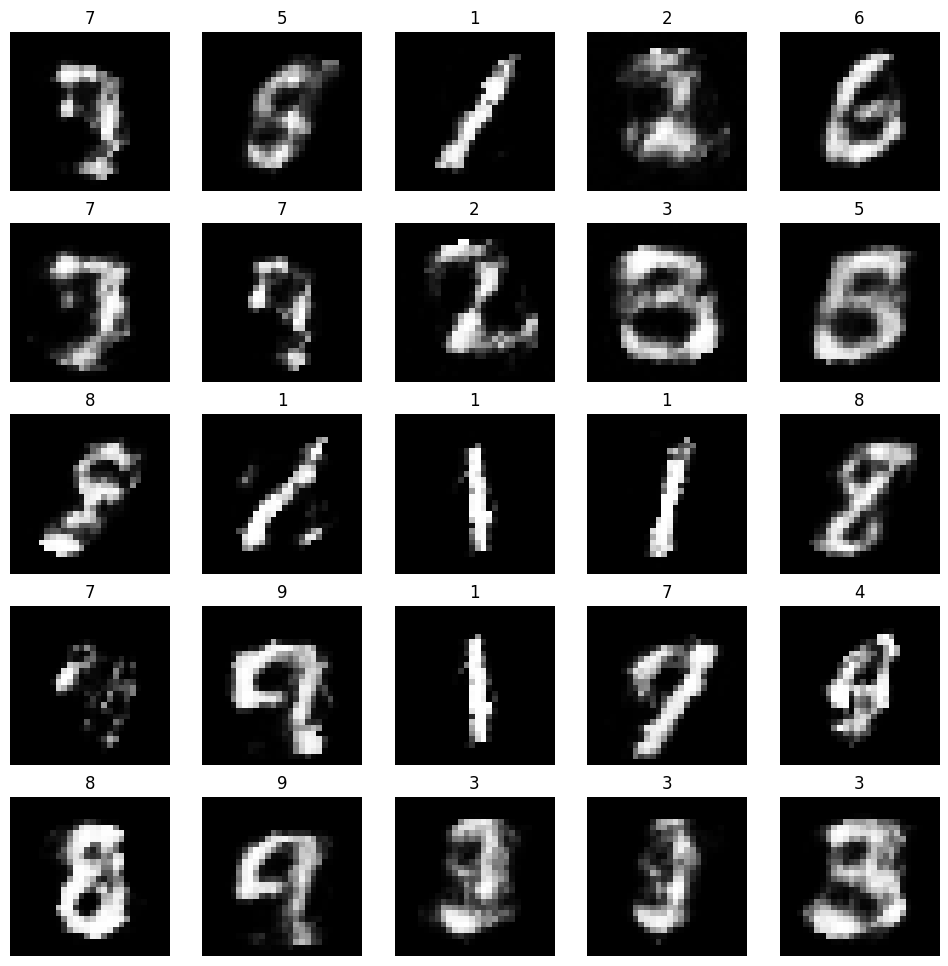

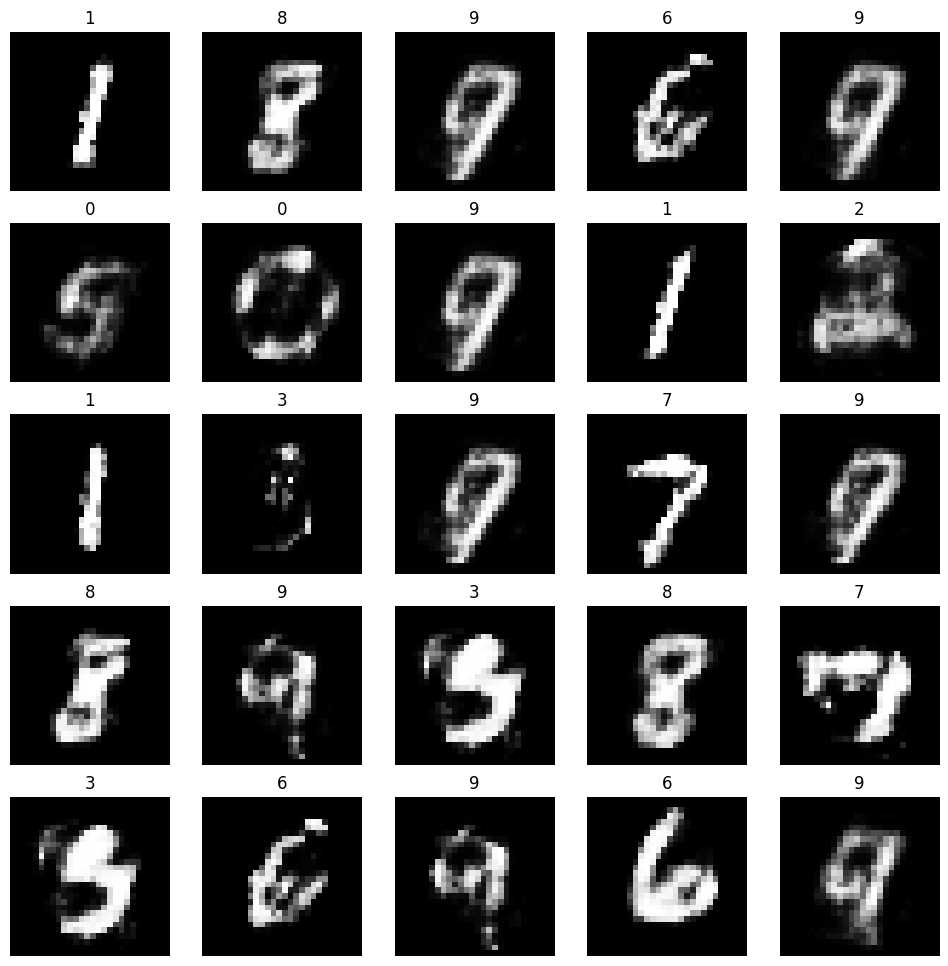

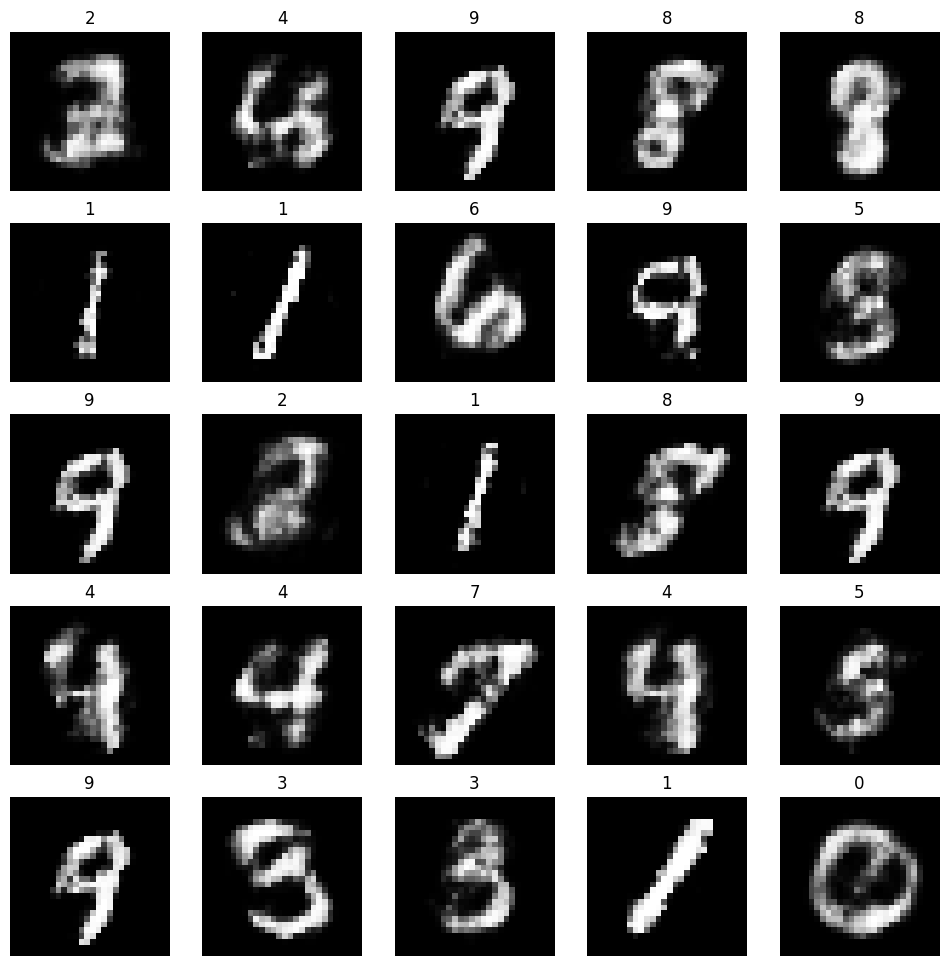

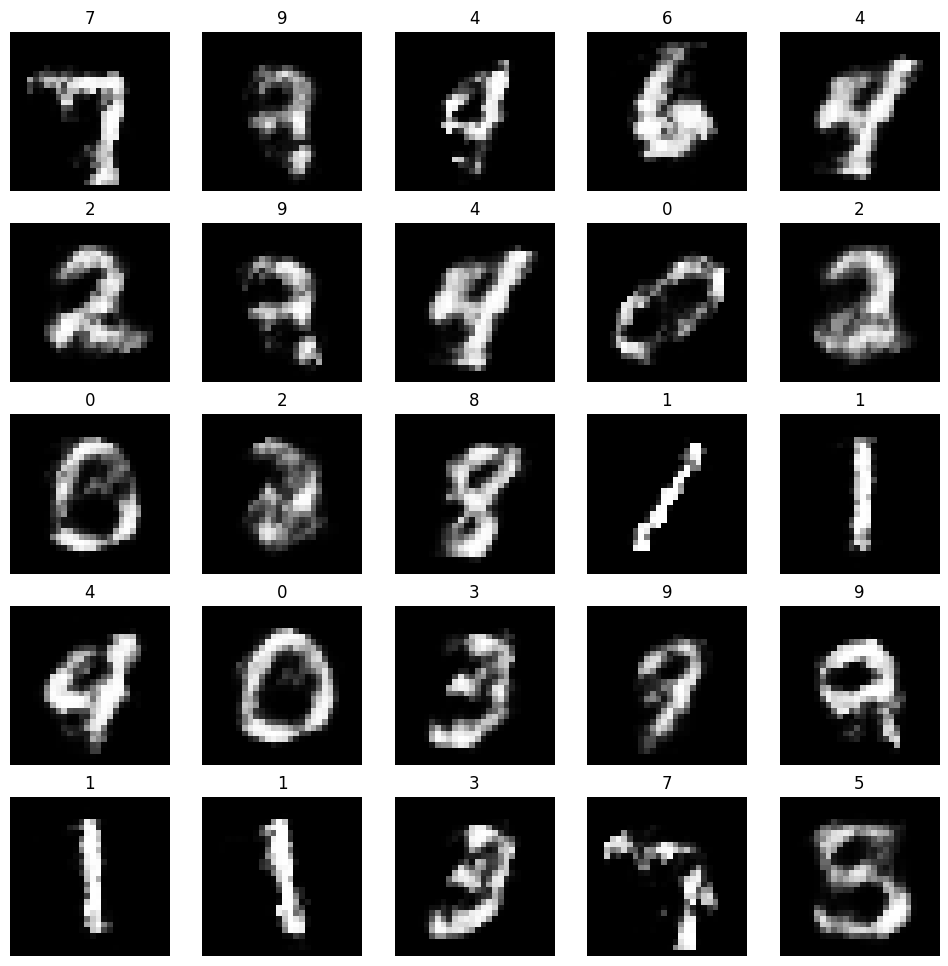

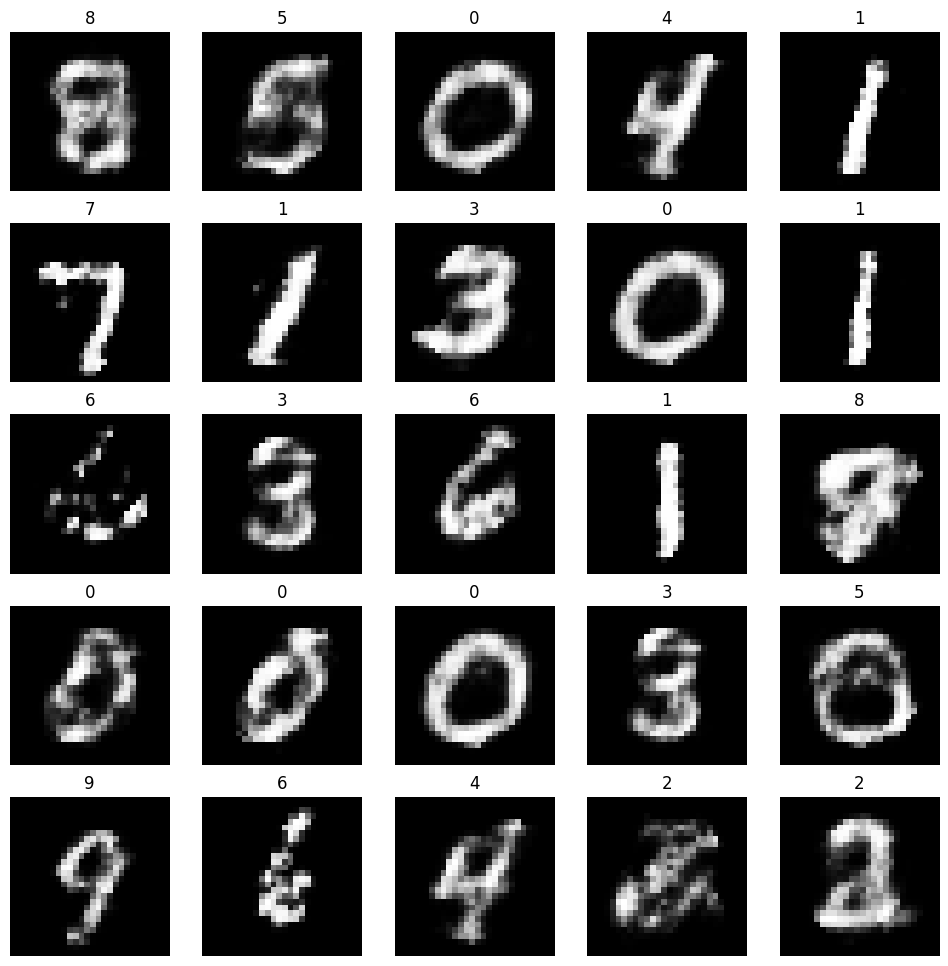

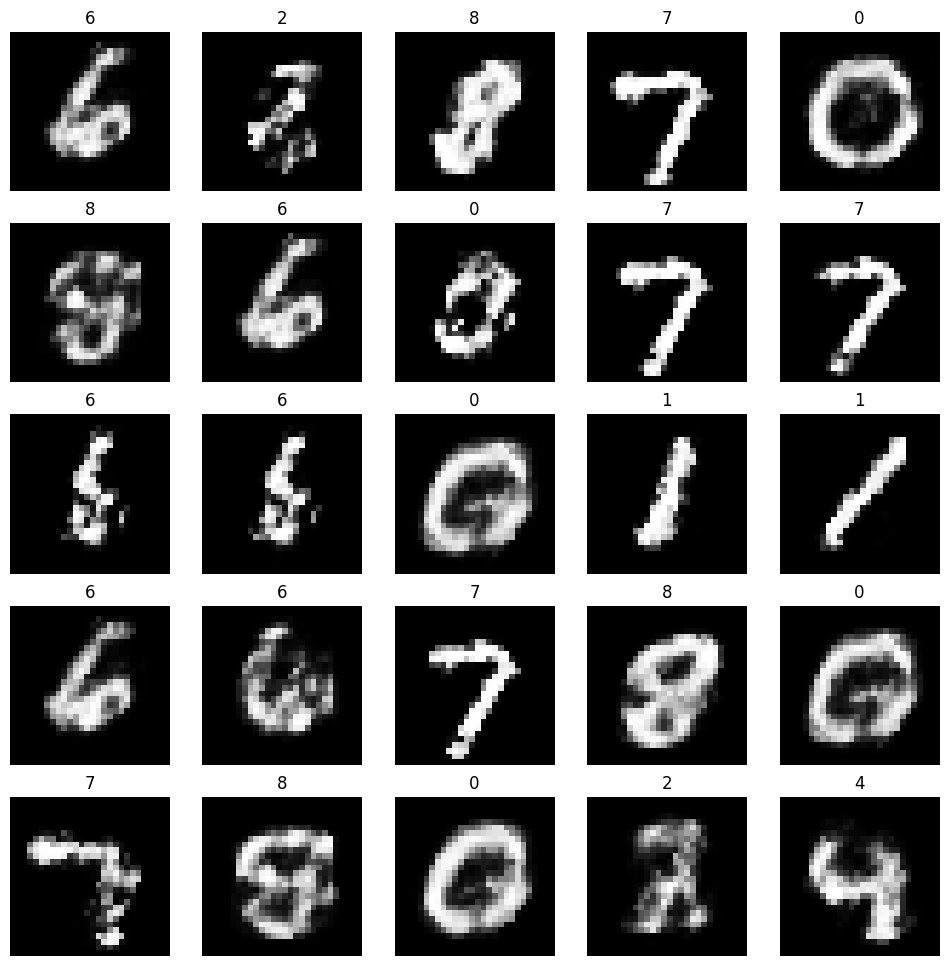

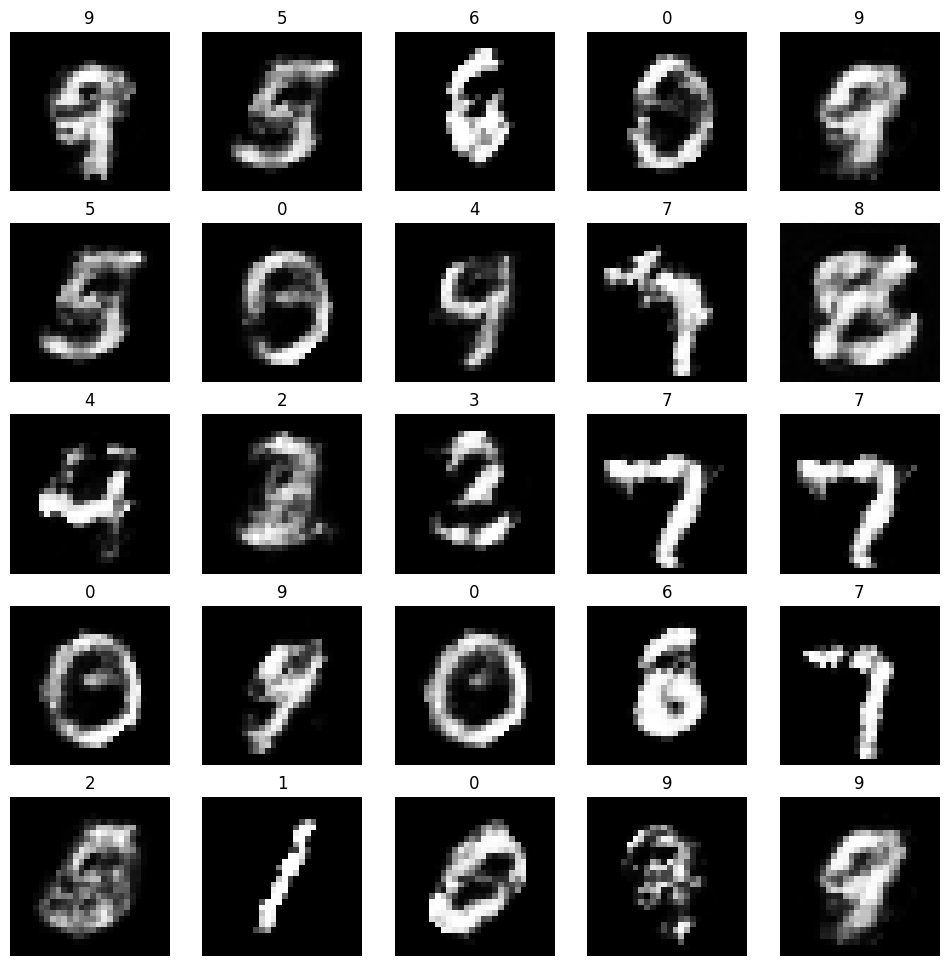

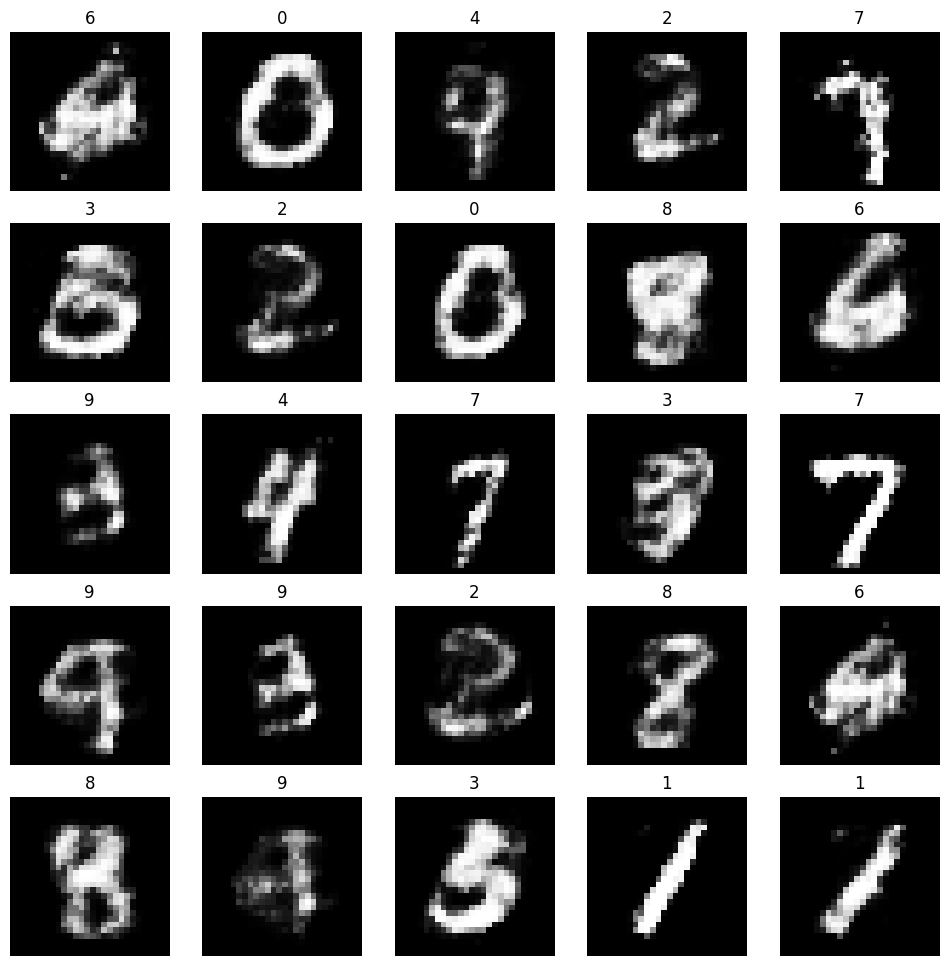

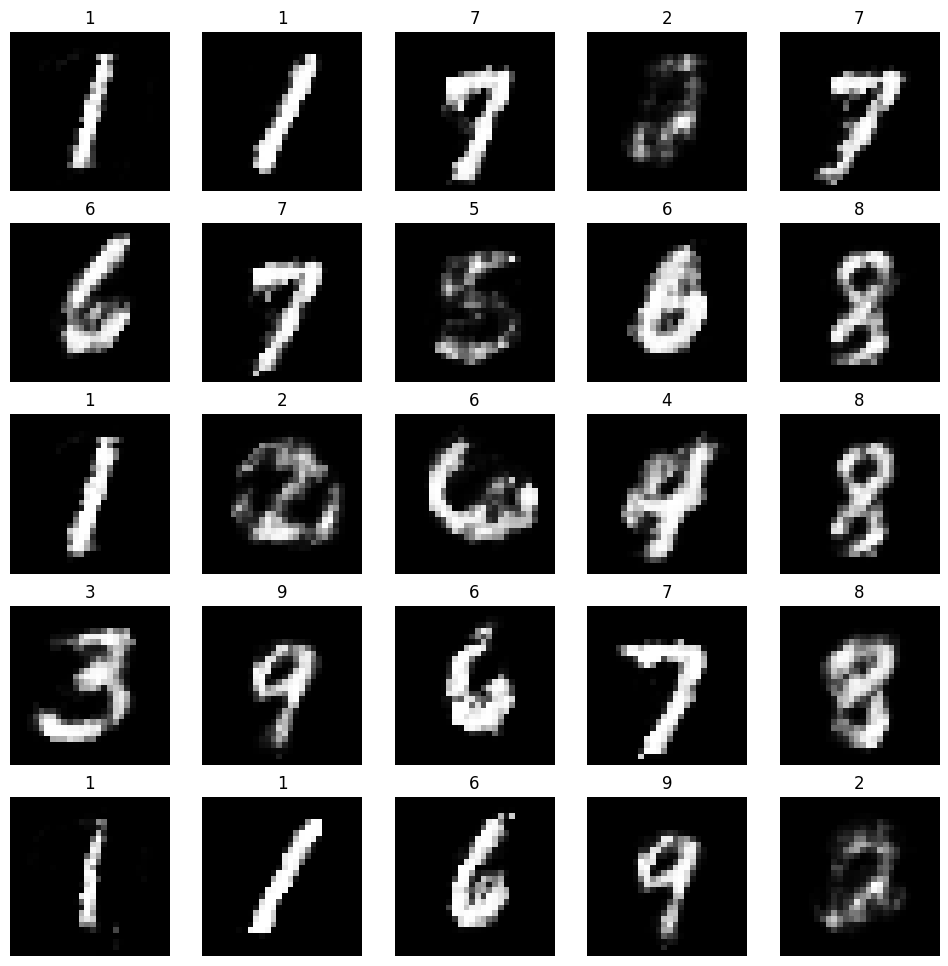

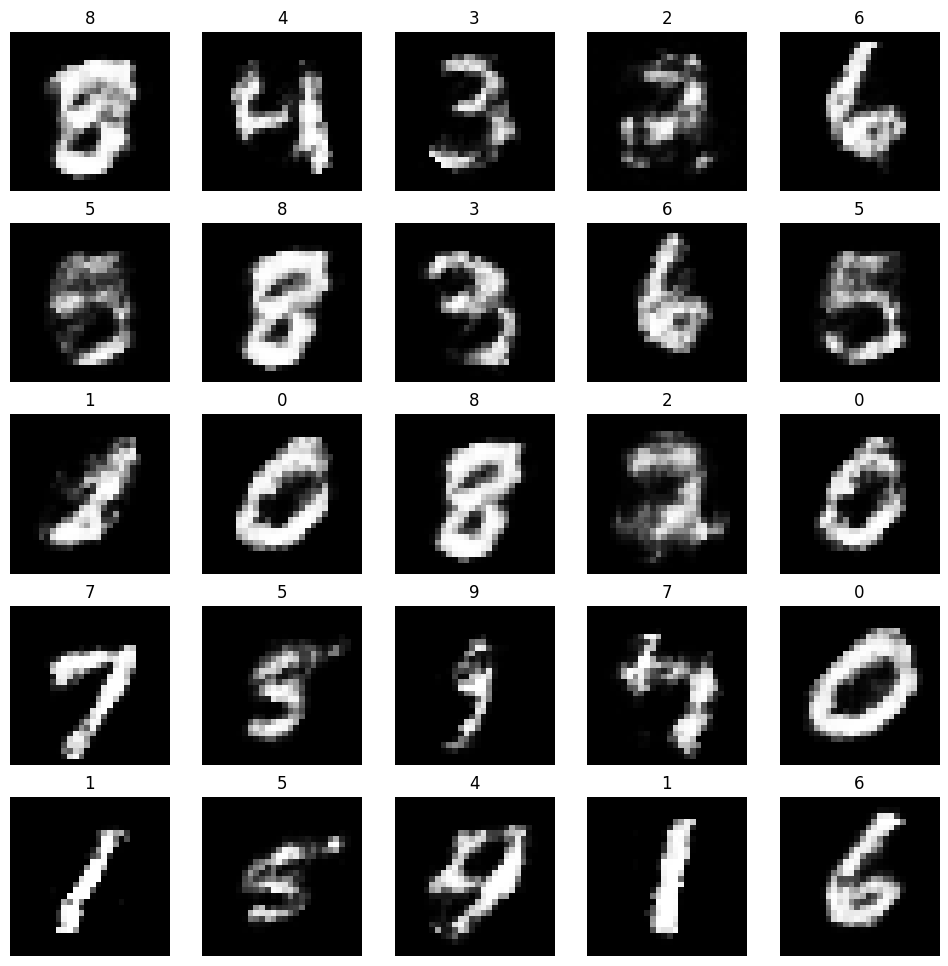

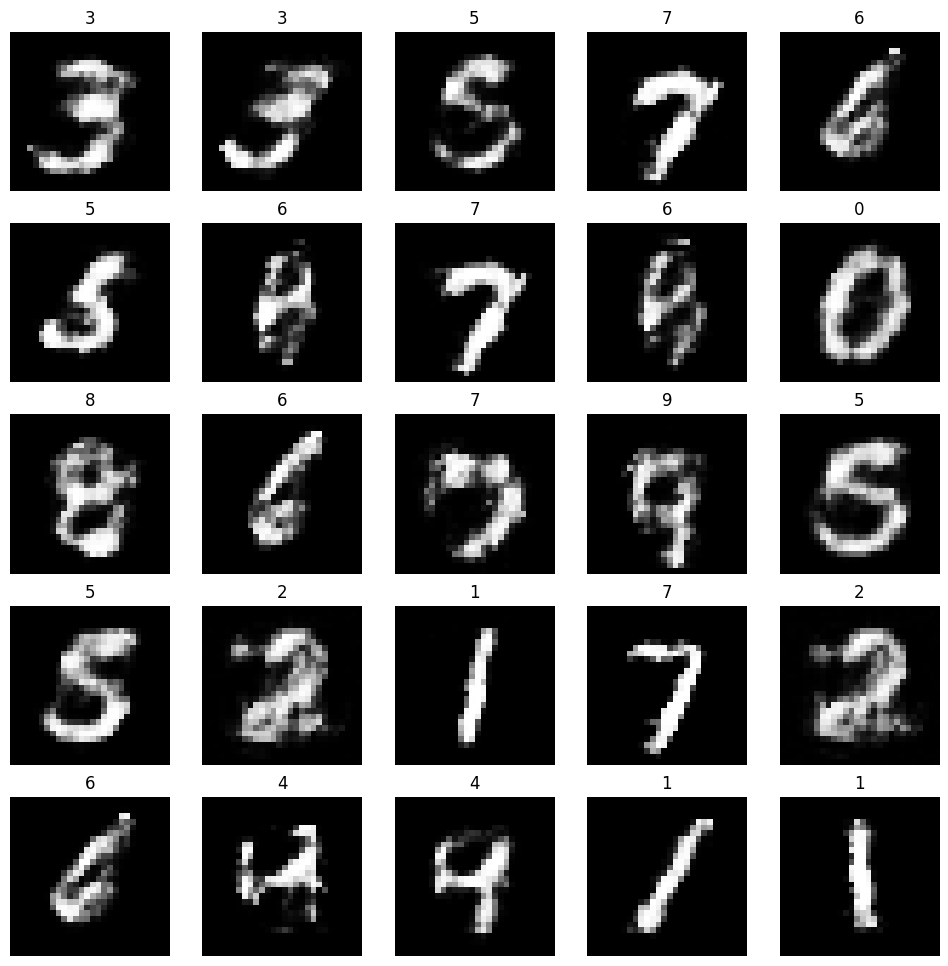

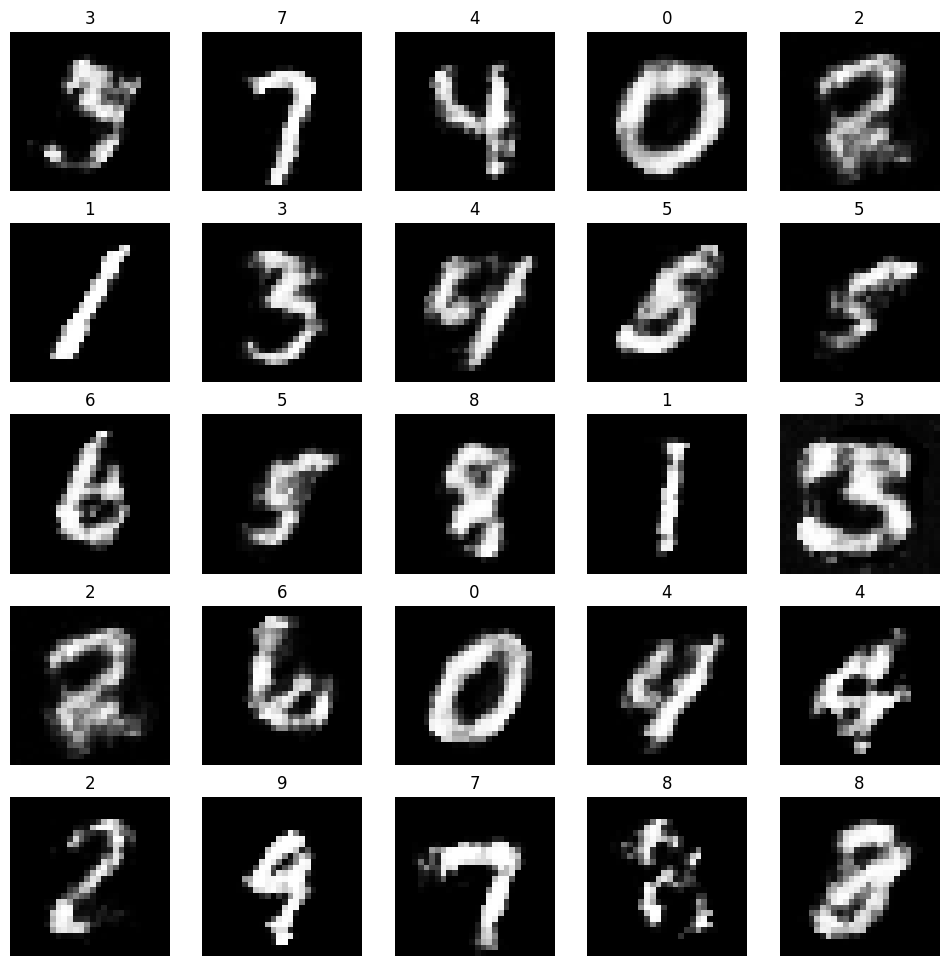

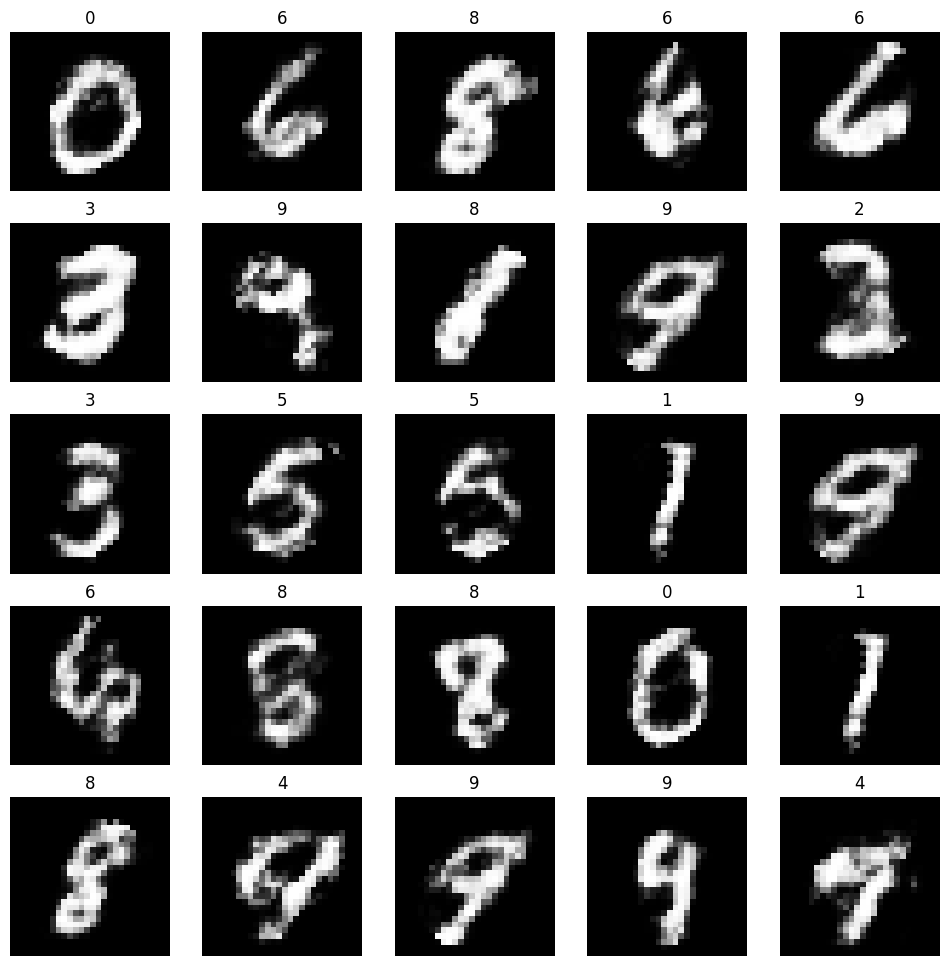

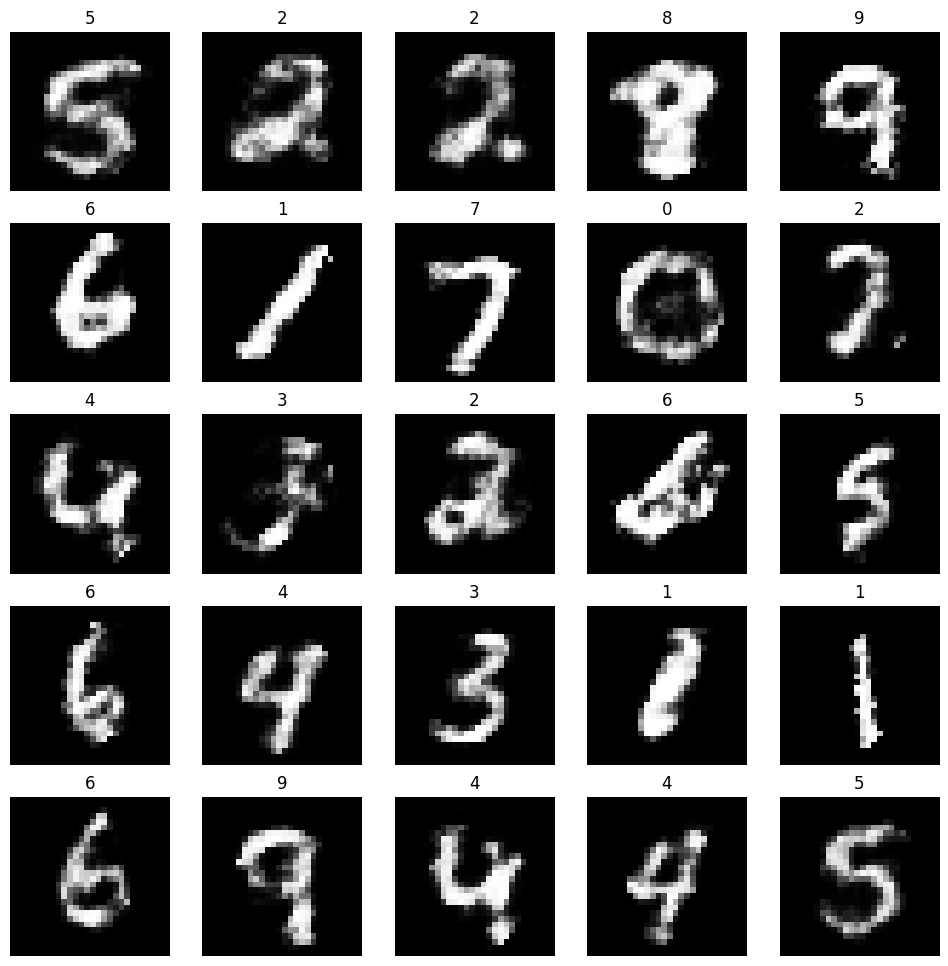

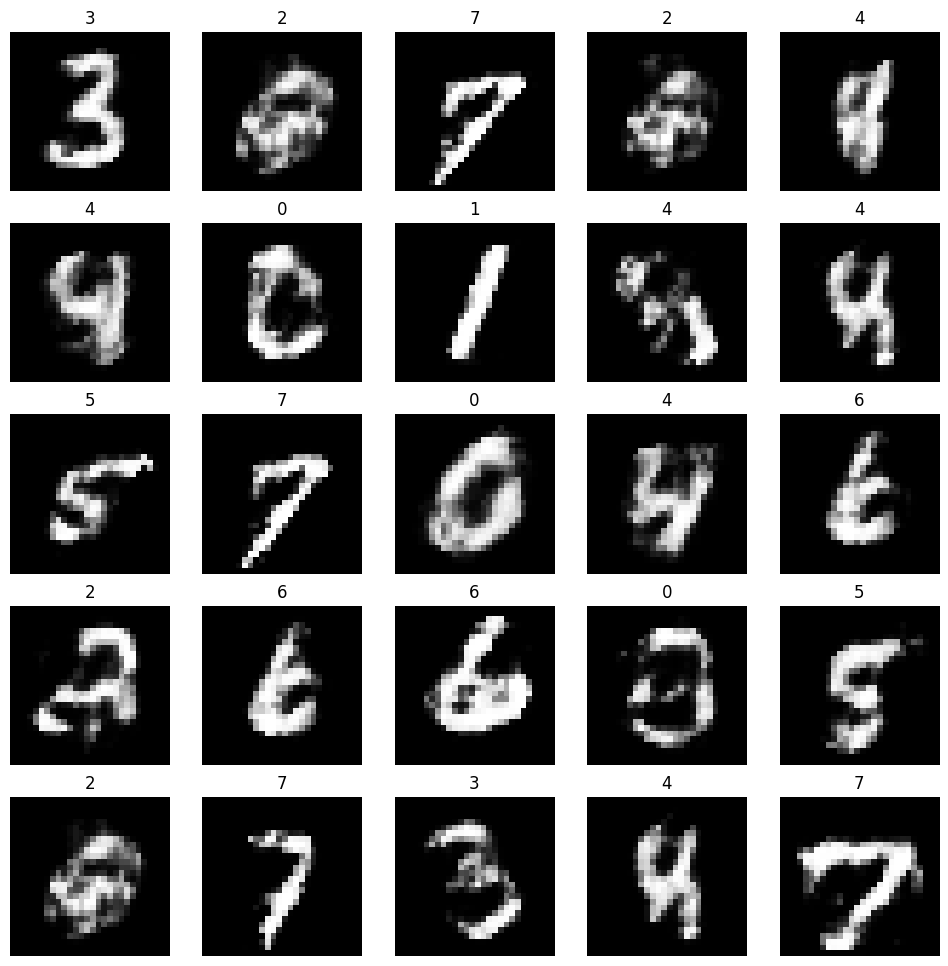

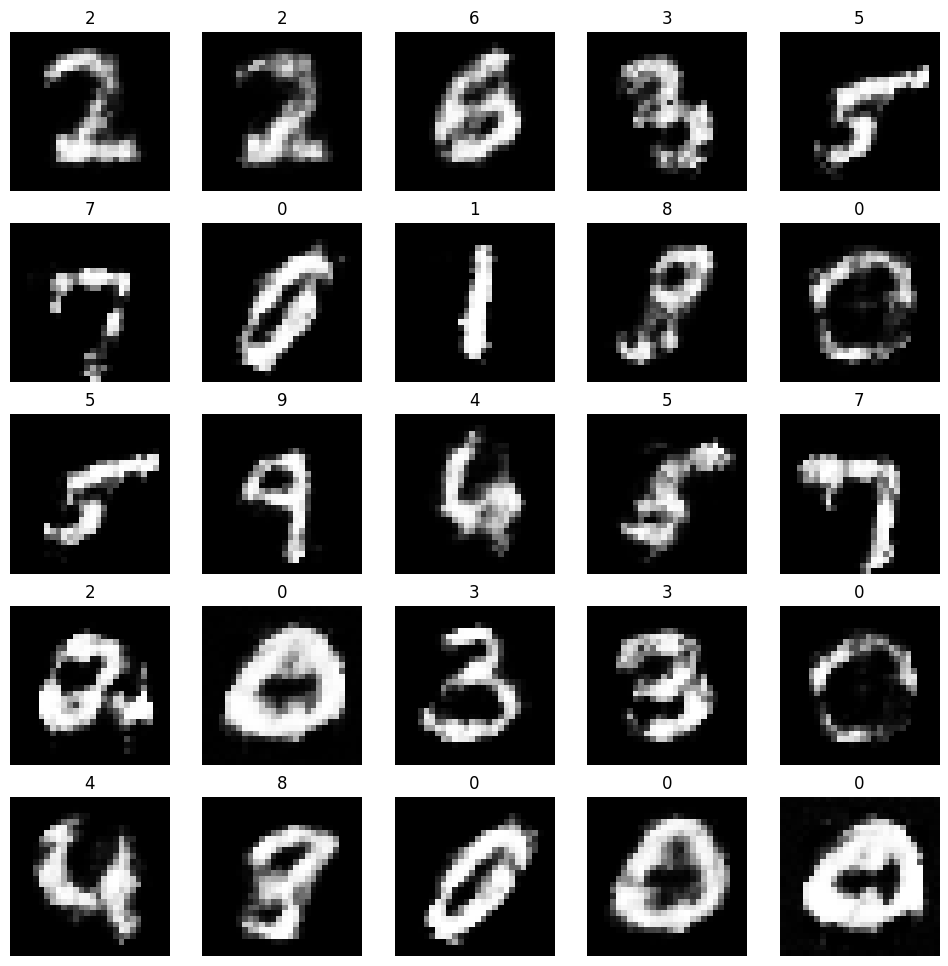

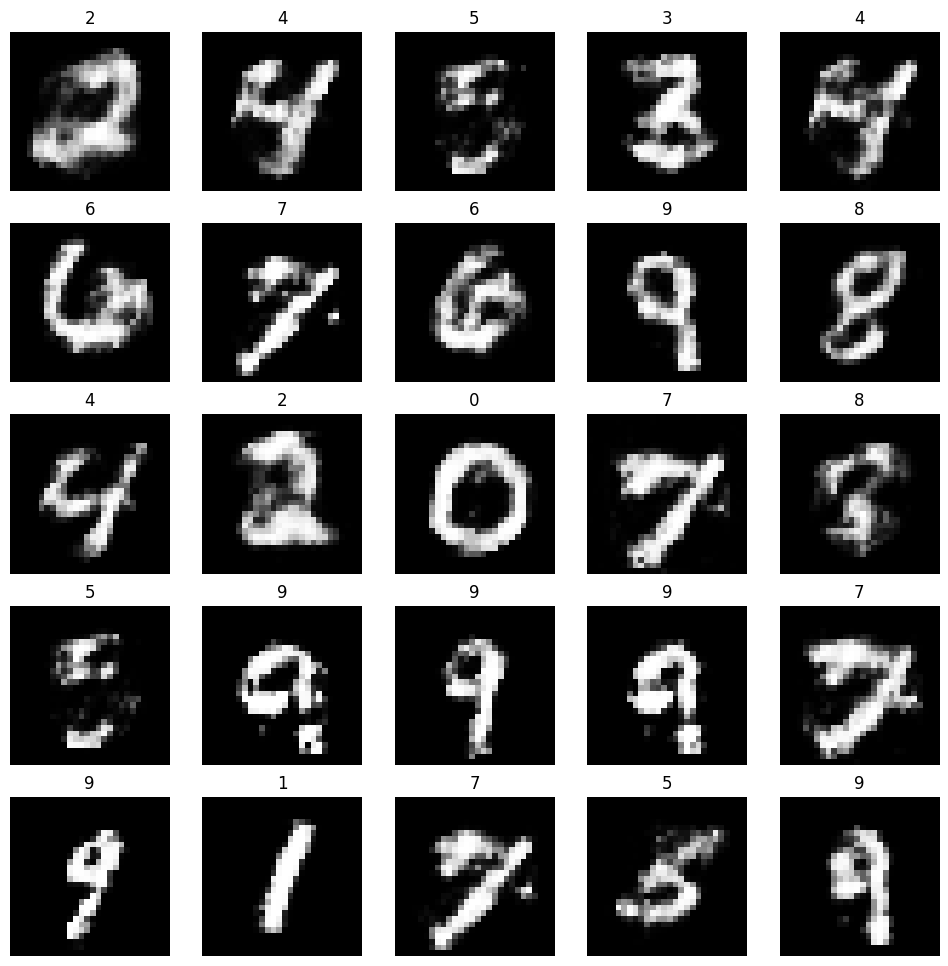

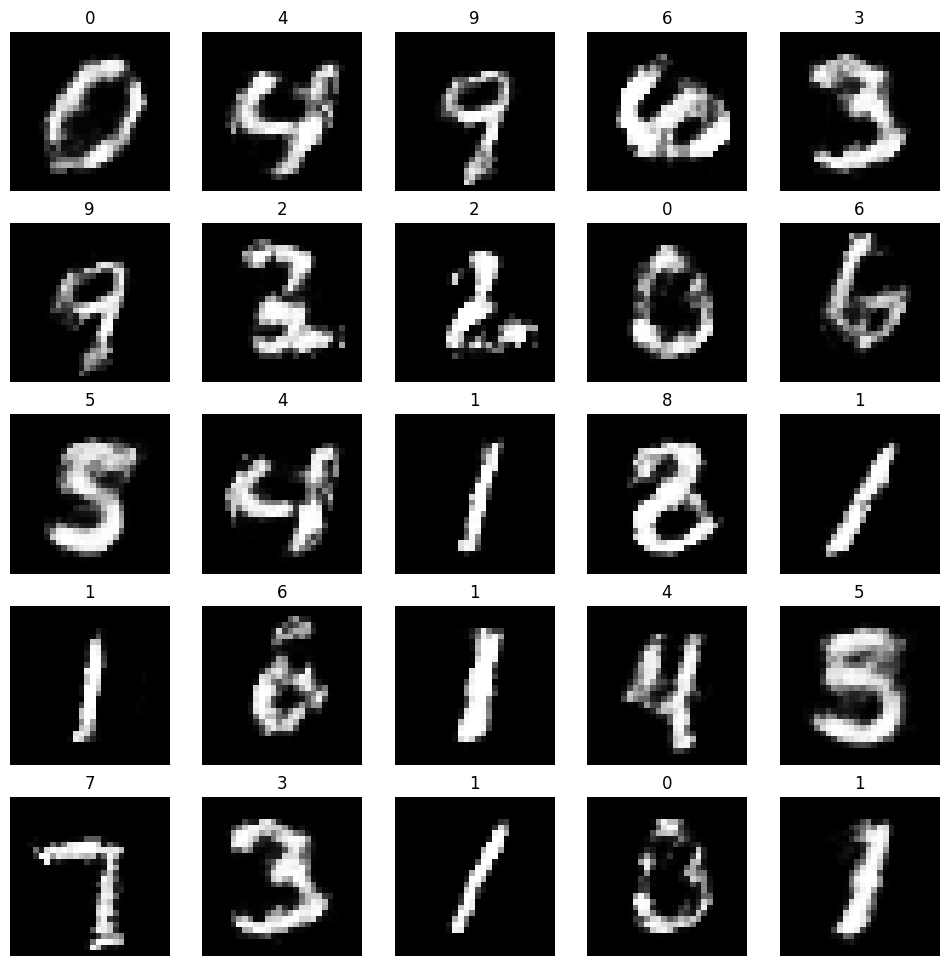

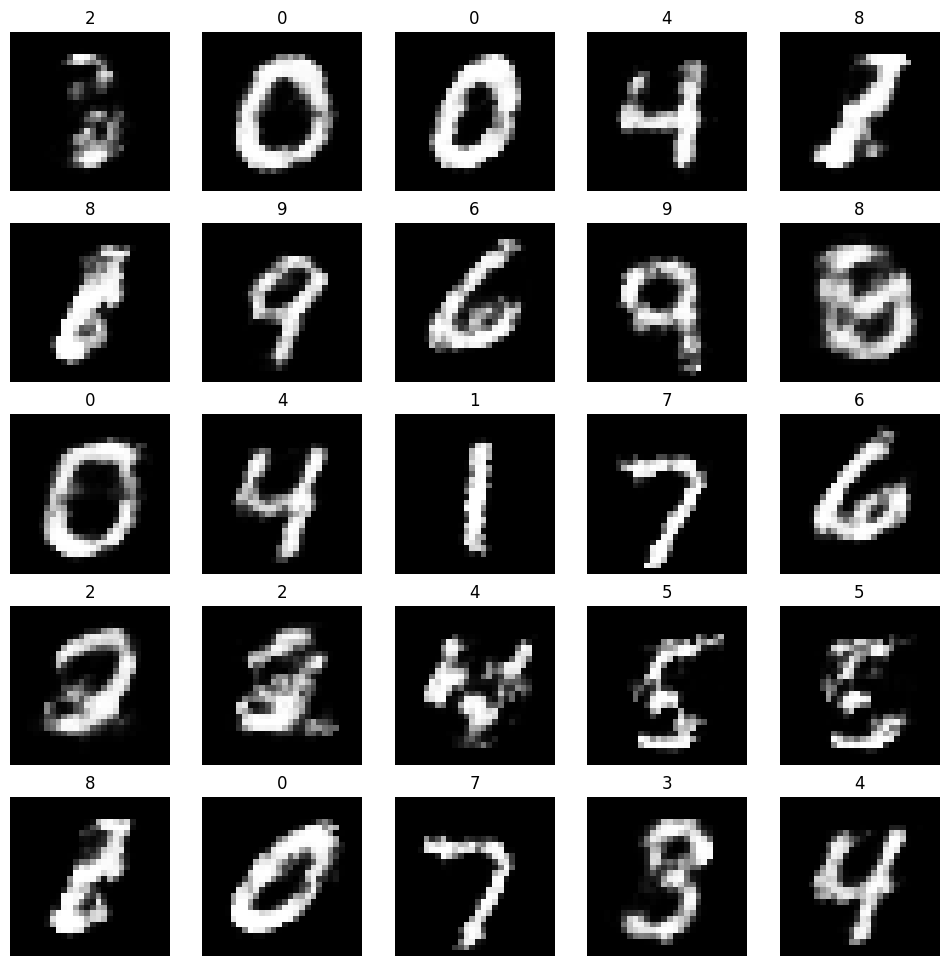

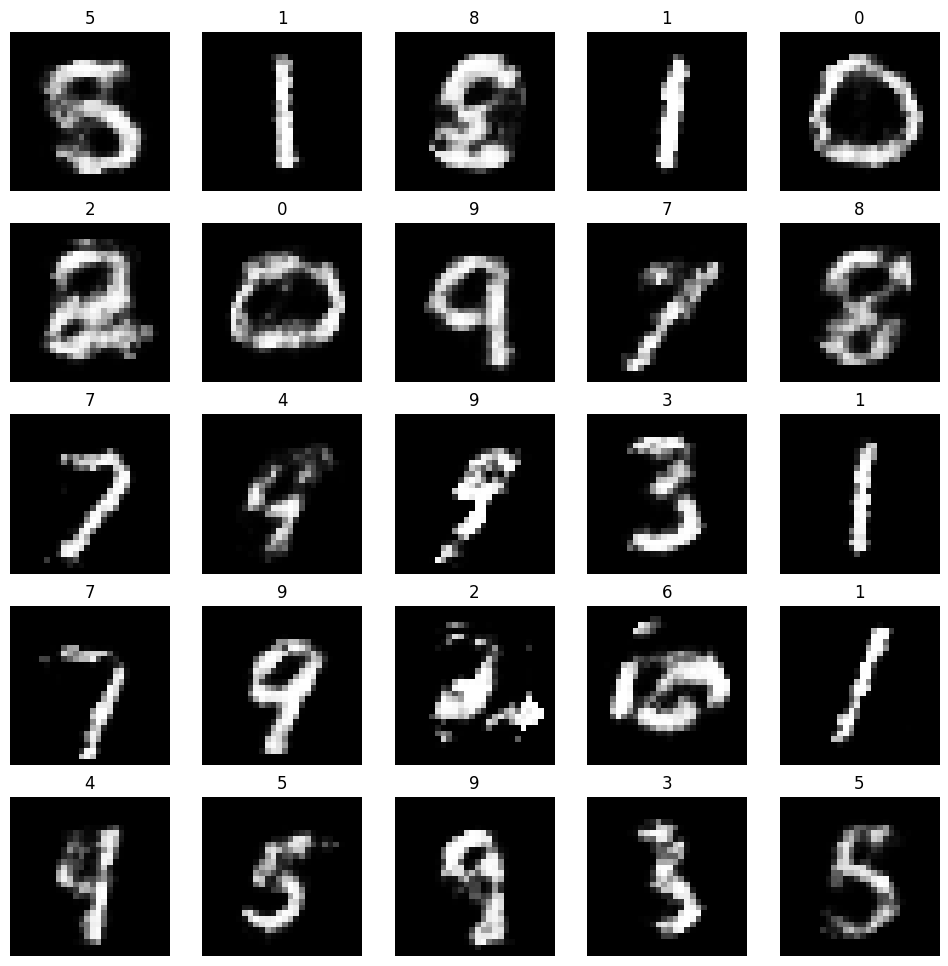

In [ ]:
epochs = 20
lambda_cls = 1
lambda_gp = 10
lambda_rec = 10
n_critic = 5
start_time = time.time()

for epoch in range(1, epochs+1) :
    for i, (real_img, label) in enumerate(dataloader) :
        # real_img : 진짜 이미지
        # label : 진짜 이미지의 레이블
        # label_rnd : 학습용 랜덤 레이블

        label = to_one_hot(label)
        rand_idx = torch.randperm(real_img.size(0))
        label_rnd = label[rand_idx]


    ### Discriminator ( real + fake + classification + gradient penalty )

        out_src, out_cls = discriminator(real_img)

        # Compute loss with real images.
        d_loss_real = - torch.mean(out_src)
        d_loss_cls = classification_loss(out_cls, label)

        # Compute loss with fake images.
        fake_img = generator(real_img, label_rnd)
        out_src, out_cls = discriminator(fake_img.detach())
        d_loss_fake = torch.mean(out_src)

        alpha = torch.rand(real_img.size(0), 1, 1, 1) # alpha : [batch_size, 1, 1, 1]

        # 실제 이미지와 가짜 이미지를 무작위로 혼합하여 생성
        x_hat = (alpha * real_img.data + (1 - alpha) * fake_img).requires_grad_(True)
        # 혼합 데이터를 판별
        out_src, _ = discriminator(x_hat)
        d_loss_gp = gradient_penalty(out_src, x_hat)

        d_loss = d_loss_real + d_loss_fake + lambda_cls * d_loss_cls + lambda_gp * d_loss_gp
        optimizer_D.zero_grad()
        optimizer_G.zero_grad()
        d_loss.backward()
        optimizer_D.step()

    ### Generator(fake + recycle + classification)
        if (i+1) % n_critic == 0 :
            # x ==> y`
            fake_img = generator(real_img, label_rnd)
            out_src, out_cls = discriminator(fake_img)
            g_loss_fake = - torch.mean(out_src)
            g_loss_cls = classification_loss(out_cls, label_rnd)

            # y` ==> x``
            recon_img = generator(fake_img, label)
            g_loss_rec = torch.mean(torch.abs(real_img - recon_img))

            g_loss = g_loss_fake + lambda_rec * g_loss_rec + lambda_cls * g_loss_cls
            optimizer_D.zero_grad()
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")
    save_image(fake_img.data[:25], f'_image_{epoch}.png', nrow=5, normalize=True)

    fig, axarr = plt.subplots(5, 5, figsize=(12, 12))
    titles = np.argmax(label_rnd[:25], axis=1)
    for ii in range(25) :

        ax = axarr[ii//5, ii%5]
        vis = fake_img[ii, 0, :, :].detach().numpy()
        ax.set_title(titles[ii].item())
        ax.imshow(vis, cmap='gray')
        ax.axis('off')
